In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [6]:
# Load Data
train_data = pd.read_csv("./content/KDDTrain+.txt")
test_data = pd.read_csv("./content/KDDTest+.txt")

In [7]:
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
           'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
           'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
           'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
           'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
           'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
           'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
           'dst_host_srv_rerror_rate', 'attack', 'level']

In [8]:
train_data.columns = columns
test_data.columns = columns

In [9]:
full_data = pd.concat([train_data, test_data], ignore_index=True)

In [10]:
# Encode categorical features
label_encoders = {}
for column in ['protocol_type', 'service', 'flag']:
    le = LabelEncoder()
    full_data[column] = le.fit_transform(full_data[column])
    label_encoders[column] = le

In [11]:
# Binary classification: normal vs. attack
full_data['attack'] = full_data['attack'].apply(lambda x: 1 if x != 'normal' else 0)

X = full_data.drop(['attack', 'level'], axis=1)
y = full_data['attack']

In [12]:
# Feature Selection with RFE
rf = RandomForestClassifier(n_estimators=100, random_state=42)
n_features_to_keep = int(0.9 * X.shape[1])
rfe = RFE(rf, n_features_to_select=n_features_to_keep)
rfe.fit(X, y)

RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=36)

In [13]:
X_rfe_selected = X.loc[:, rfe.support_]
feature_ranks = pd.DataFrame({'Feature': X.columns, 'Rank': rfe.ranking_, 'Selected': rfe.support_})

In [14]:
# Display selected features
print("Selected Features:", list(X_rfe_selected.columns))
print("Number of Features Retained:", X_rfe_selected.shape[1])


Selected Features: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
Number of Features Retained: 36


In [15]:
# Sort and display feature rankings (1 means most important)
feature_ranks = feature_ranks.sort_values(by='Rank')
print("\nFeature Importance Ranking (Lower is Better):")
print(feature_ranks)


Feature Importance Ranking (Lower is Better):
                        Feature  Rank  Selected
0                      duration     1      True
22                        count     1      True
23                    srv_count     1      True
24                  serror_rate     1      True
25              srv_serror_rate     1      True
26                  rerror_rate     1      True
27              srv_rerror_rate     1      True
28                same_srv_rate     1      True
29                diff_srv_rate     1      True
30           srv_diff_host_rate     1      True
31               dst_host_count     1      True
32           dst_host_srv_count     1      True
33       dst_host_same_srv_rate     1      True
34       dst_host_diff_srv_rate     1      True
35  dst_host_same_src_port_rate     1      True
36  dst_host_srv_diff_host_rate     1      True
37         dst_host_serror_rate     1      True
38     dst_host_srv_serror_rate     1      True
21               is_guest_login     1    

In [16]:
# Mutual Information for Feature Filtering
mi_scores = mutual_info_classif(X_rfe_selected, y, random_state=42)
mi_threshold = np.percentile(mi_scores, 20)
final_selected_features = X_rfe_selected.columns[mi_scores > mi_threshold]
X_final = X_rfe_selected[final_selected_features]

In [17]:
print("Mutual Information Threshold (30th percentile):", mi_threshold)

Mutual Information Threshold (30th percentile): 0.0035042596418286553


<Axes: >

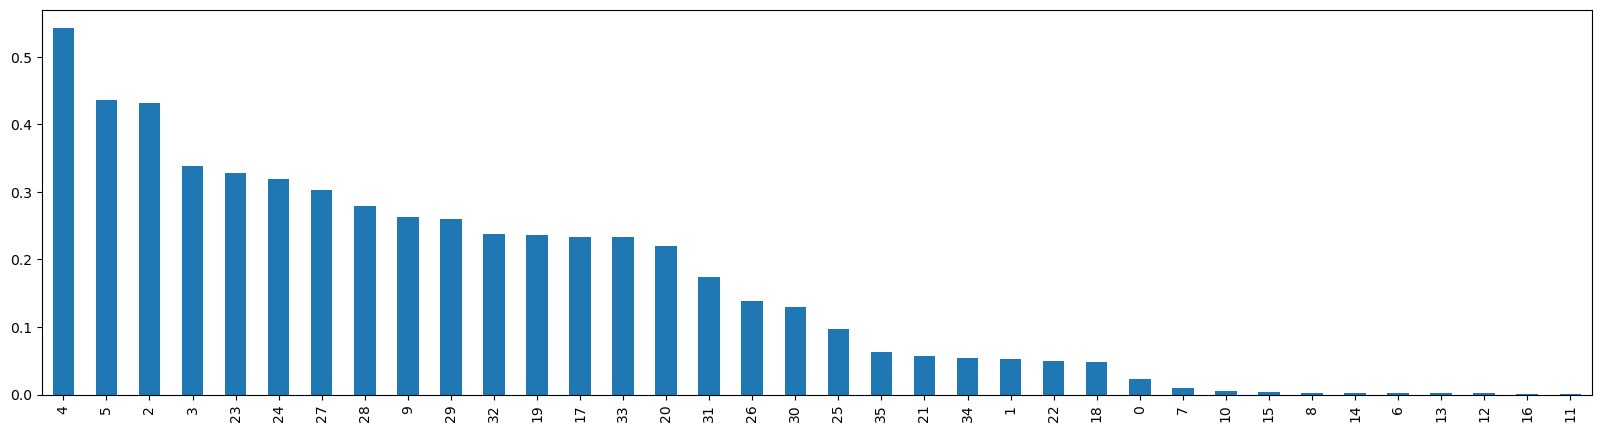

In [18]:
import pandas as pd

mi_scores = pd.Series(mi_scores)  # Convert NumPy array to Pandas Series
mi_scores.sort_values(ascending=False).plot.bar(figsize=(20, 5))


In [19]:
# Display the selected features
print("Selected Features after Mutual Information Filtering:")
print(final_selected_features.tolist())
print(f"\nNumber of Columns Retained: {len(final_selected_features)}")

Selected Features after Mutual Information Filtering:
['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'hot', 'logged_in', 'num_compromised', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

Number of Columns Retained: 28


In [20]:
# Standardize Data
scaler = StandardScaler()
X_final = scaler.fit_transform(X_final)

In [21]:
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

In [22]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso_forest.fit(X_final)

IsolationForest(contamination=0.1, random_state=42)

In [23]:
# Step 2: Predict Anomalies
iso_labels = iso_forest.predict(X_final)
iso_labels = np.where(iso_labels == -1, 1, 0)  # Convert anomalies (-1) to attack (1), normal (1) to 0


In [24]:
# Step 3: Filter Data
X_filtered = X_final[iso_labels == 0]  # Keep normal data for LSTM training
y_filtered = y[iso_labels == 0]

In [25]:
X_filtered = X_filtered.reshape((X_filtered.shape[0], 1, X_filtered.shape[1]))

In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

X_filtered = np.array(X_filtered)
y_filtered = np.array(y_filtered)

# Define LSTM input shape
timesteps = 1  # Adjust as needed
features = X_filtered.shape[1]

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_accuracies, fold_precisions, fold_recalls, fold_f1s = [], [], [], []

In [27]:
for fold, (train_index, test_index) in enumerate(kf.split(X_filtered, y_filtered), 1):
    X_train, X_test = X_filtered[train_index], X_filtered[test_index]
    y_train, y_test = y_filtered[train_index], y_filtered[test_index]

    # Print data shapes before reshaping
    print(f"Fold {fold} - Before Reshaping:")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    # Reshape for LSTM only if needed
    if len(X_train.shape) == 2:
        X_train = X_train.reshape(X_train.shape[0], timesteps, features)
        X_test = X_test.reshape(X_test.shape[0], timesteps, features)

    print(f"Fold {fold} - After Reshaping: X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

    # Skip fold if only one class in y_train
    if len(np.unique(y_train)) < 2:
        print(f"Skipping Fold {fold} (Only one class in training data)")
        continue


    # LSTM Model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    # Predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Calculate Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    fold_accuracies.append(acc)
    fold_precisions.append(prec)
    fold_recalls.append(rec)
    fold_f1s.append(f1)

    # Print fold results
    print(f"Fold {fold} Results:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("-" * 50)


Fold 1 - Before Reshaping:
X_train shape: (120296, 1, 28), y_train shape: (120296,)
X_test shape: (13367, 1, 28), y_test shape: (13367,)
Fold 1 - After Reshaping: X_train shape: (120296, 1, 28), X_test shape: (13367, 1, 28)




418/418 [==============================] - 1s 2ms/step
Fold 1 Results:
[[7263   65]
 [  74 5965]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7328
           1       0.99      0.99      0.99      6039

    accuracy                           0.99     13367
   macro avg       0.99      0.99      0.99     13367
weighted avg       0.99      0.99      0.99     13367

--------------------------------------------------
Fold 2 - Before Reshaping:
X_train shape: (120296, 1, 28), y_train shape: (120296,)
X_test shape: (13367, 1, 28), y_test shape: (13367,)
Fold 2 - After Reshaping: X_train shape: (120296, 1, 28), X_test shape: (13367, 1, 28)
418/418 [==============================] - 1s 2ms/step
Fold 2 Results:
[

Average Accuracay: 0.9885
Average Precision: 0.9891
Average Recall: 0.9853
Average F1-score: 0.9872


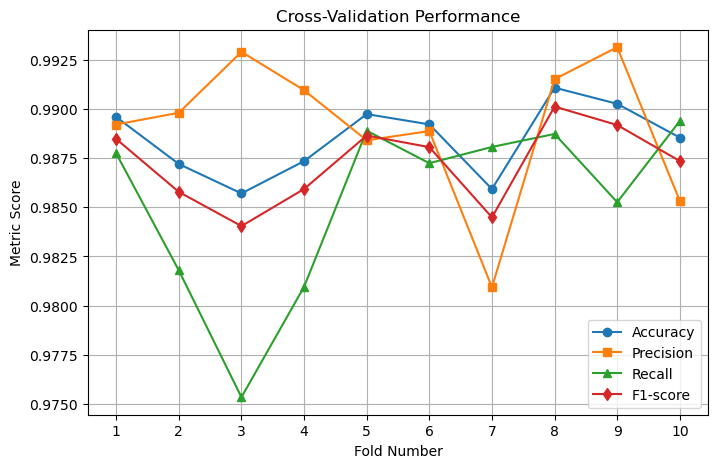

In [28]:
if fold_accuracies:
    avg_acc = np.mean(fold_accuracies)
    avg_prec = np.mean(fold_precisions)
    avg_rec = np.mean(fold_recalls)
    avg_f1 = np.mean(fold_f1s)

    print(f"Average Accuracay: {avg_acc:.4f}")
    print(f"Average Precision: {avg_prec:.4f}")
    print(f"Average Recall: {avg_rec:.4f}")
    print(f"Average F1-score: {avg_f1:.4f}")

    #Plot performance across folds
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(fold_accuracies) + 1), fold_accuracies, marker='o', label='Accuracy')
    plt.plot(range(1, len(fold_precisions) + 1), fold_precisions, marker='s', label='Precision')
    plt.plot(range(1, len(fold_recalls) + 1), fold_recalls, marker='^', label='Recall')
    plt.plot(range(1, len(fold_f1s) + 1), fold_f1s, marker='d', label='F1-score')

    plt.xticks(range(1, len(fold_accuracies) + 1))
    plt.xlabel('Fold Number')
    plt.ylabel('Metric Score')
    plt.title('Cross-Validation Performance')
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("No valid folds with both classes. Check dataset balance.")